<a href="https://colab.research.google.com/github/MutiaraZaafira/Machine-Learning-Task/blob/main/Machine_Leaning_12thWeek_Task2_Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MUTIARA ZAAFIRA ITONSASPUTRI (1103184228) TK-42-G6

In [ ]:
!pip install d2l==0.17.1

In [ ]:
!pip install -U mxnet-cu101==1.7.0

     |███████████████████████████████▌| 834.1 MB 1.2 MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x55ed04fca000 @  0x7fe1cf81f615 0x55eccaa704cc 0x55eccab5047a 0x55eccaa732ed 0x55eccab64e1d 0x55eccaae6e99 0x55eccaae19ee 0x55eccaa74bda 0x55eccaae6d00 0x55eccaae19ee 0x55eccaa74bda 0x55eccaae3737 0x55eccab65c66 0x55eccaae2daf 0x55eccab65c66 0x55eccaae2daf 0x55eccab65c66 0x55eccaae2daf 0x55eccaa75039 0x55eccaab8409 0x55eccaa73c52 0x55eccaae6c25 0x55eccaae19ee 0x55eccaa74bda 0x55eccaae3737 0x55eccaae19ee 0x55eccaa74bda 0x55eccaae2915 0x55eccaa74afa 0x55eccaae2c0d 0x55eccaae19ee
     |████████████████████████████████| 846.0 MB 20 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
from mxnet import autograd, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `autograd` to determine whether the current mode is training mode or
    # prediction mode
    if not autograd.is_training():
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        X_hat = (X - moving_mean) / np.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(axis=0)
            var = ((X - mean) ** 2).mean(axis=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X - mean) ** 2).mean(axis=(0, 2, 3), keepdims=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / np.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean, moving_var

In [ ]:
class BatchNorm(nn.Block):
    # `num_features`: the number of outputs for a fully-connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully-connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims, **kwargs):
        super().__init__(**kwargs)
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = self.params.get('gamma', shape=shape, init=init.One())
        self.beta = self.params.get('beta', shape=shape, init=init.Zero())
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = np.zeros(shape)
        self.moving_var = np.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.ctx != X.ctx:
            self.moving_mean = self.moving_mean.copyto(X.ctx)
            self.moving_var = self.moving_var.copyto(X.ctx)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma.data(), self.beta.data(), self.moving_mean,
            self.moving_var, eps=1e-12, momentum=0.9)
        return Y

Applying Batch Normalization in LeNet

In [ ]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        BatchNorm(6, num_dims=4),
        nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        BatchNorm(16, num_dims=4),
        nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        BatchNorm(120, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        BatchNorm(84, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(10))

loss 0.268, train acc 0.902, test acc 0.858
309.2 examples/sec on cpu(0)


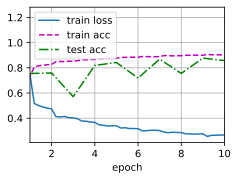

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
net[1].gamma.data().reshape(-1,), net[1].beta.data().reshape(-1,)

(array([3.0727267, 1.6004426, 3.23145  , 2.2281613, 2.2425725, 4.2151265]),
 array([ 2.538142 ,  1.7854295, -3.0738032,  2.0288596, -0.5239617,
         2.3239098]))

Concise Implementation

In [ ]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(10))

loss 0.273, train acc 0.898, test acc 0.867
2247.6 examples/sec on cpu(0)


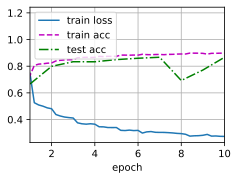

In [ ]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())